In [1]:
#imports
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import gas_density as rho_g_fun # Temp IN C and Pressure in PSI
%matplotlib inline

In [2]:
# Core Parameters
L=7.62 #sample length (m)
r=0.00493/2 #sample radius (m)
A=m.pi*r**2 #sample area (m^2)
V_sample=A*L #sample volume (m^3)
por=.39 #sample porosity (-)
Vp=V_sample*por #sample pore volume (m^3)
Vp_ml=Vp*10**6
V_line=5 #volume of lines, fittings, etc
R=8.314 #gas constants (Pa m^3)/(mol k)
R2=8314.46261815324  #gas constants (Pa L)/(mol k)
#BPR=825 #BPR set pressure

In [3]:
# IMPORT DATA: 140 - with hydrate / 120 - no hydrate
df=pd.read_excel('ST140_gas.xlsx')

df['Gas out']=df['Gas out']*1.1
df['PV in']=df['Gas in']/4.96
df['PV out']=df['Gas out']/4.96

df2=pd.read_excel('ST120_gas.xlsx')


df2['PV in']=df2['Gas in']/1.48
df2['PV out']=df2['Gas out']/1.48

In [4]:
# Density
df['rho_g_m'],df['Z']=rho_g_fun.CH4_EOS(df['T'],df['P down']) #density (mol/m3) and Z
rho_h=912*1000/124+(912*1000/124)*5.75 #density of hydrate (mol/m^3)
rho_l=1027.6*1000/18.02 #(mol/m^3)  #1027.6 #kg/m^3 # !ASSUME TO BE CONSTANT BUT CAN ADD FUCTION TO UPDATE!

In [5]:
# Known Constants
Xwg=0; Xmg=1 #mass fractions in gas phase (gas is pure methane) 
Xmh=0.17; Xwh=0.83  #mol fractions in hydrate phase
Xml=0.0007; Xwl=1-Xml

In [6]:
# Initial Conditions
Sli=0.75 #intial liquid saturation
Sgi=0.0 # initial gas saturation
Shi=0.25 #initial hydrate saturation

In [7]:
#  Initial Moles
mWi=(Xwl*Sli*rho_l+Xwh*Shi*rho_h)*Vp #mols of h2o
mGi=(Xml*Sli*rho_l+Xmg*Sgi*df['rho_g_m'][0]+Xmh*Shi*rho_h)*Vp #mols of ch4

In [8]:
# mol in and mol out each time step
df['mGas in']=(df['Gas in']*0.000001)*df['rho_g_m'] #ml at reservoir conditions to mol gas
df['mGas out']=(df['Gas out']*0.000001)*df['rho_g_m'] #mol gas out

df['mWater in']=df['Water in']*.000001*rho_l*Xwl #mol water in
df['mWater out']=df['Water out']*.000001*rho_l*Xwl #mol water out

df['deltamG']=df['mGas in'].diff()-df['mGas out'].diff() #change in mass of gas in system (kg)
df['deltamW']=df['mWater in'].diff()-df['mWater out'].diff() #change in mass of water in system (kg)

df=df.fillna(0)

df['mGAS']=mGi+df['deltamG'].cumsum() #mol of gas
df['mH2O']=mWi+df['deltamW'].cumsum() #mol of water

In [9]:
# Matrix to solve for Saturation
sat=pd.DataFrame(columns=['time','Sl','Sg','Sh'])
for i,row in df.iterrows():
    A=np.array([[1, 1, 1],
                [Xwl*rho_l, Xwg*df['rho_g_m'][i],Xwh*rho_h],
                [Xml*rho_l, Xmg*df['rho_g_m'][i], Xmh*rho_h]]) 
   
    B=np.array([1,df['mH2O'][i]/Vp,df['mGAS'][i]/Vp])
    X=np.linalg.solve(A,B)
    
    sat=sat.append({'Sh':X[2],'Sg':X[1],'Sl':X[0],'time':df['time'][i]},ignore_index=True)

In [10]:
# Calculate max CO2
df['max CO2 l']=sat['Sl']*.0059
df['max CO2 g']=(((sat['Sg']*Vp)*6.8948E+6)/(R*281))*.2
df['max CO2']=df['max CO2 l']+df['max CO2 g']

In [13]:
# Total mols in core
df['delta total mols in']=(df['Gas in'].diff()*101325)/(R2*293.15)
df['total mols in']=df['delta total mols in'].cumsum()
df['delta total mols out']=(df['Gas out'].diff()*101325)/(R2*293.15)
df['total mols out']=df['delta total mols out'].cumsum()

df2['delta total mols in']=(df2['Gas in'].diff()*101325)/(R2*293.15)
df2['total mols in']=df2['delta total mols in'].cumsum()
df2['delta total mols out']=(df2['Gas out'].diff()*101325)/(R2*293.15)
df2['total mols out']=df2['delta total mols out'].cumsum()

In [14]:
#CALCULATE MOLS OF CO2 IN CORE
df['delta CO2 mols in']=df['delta total mols in']*.2
df['CO2 mols in']=df['delta CO2 mols in'].cumsum()
df['delta CO2 mols out']=df['delta total mols out']*df['%CO2 out']
df['CO2 mols out']=df['delta CO2 mols out'].cumsum()

df['CO2 in core']=df['CO2 mols in']-df['CO2 mols out']



df2['delta CO2 mols in']=df2['delta total mols in']*.2
df2['CO2 mols in']=df2['delta CO2 mols in'].cumsum()
df2['delta CO2 mols out']=df2['delta total mols out']*df2['%CO2 out']
df2['CO2 mols out']=df2['delta CO2 mols out'].cumsum()

df2['CO2 in core']=df2['CO2 mols in']-df2['CO2 mols out']


In [15]:
#CALCULATE MOLS OF N2 IN CORE
df['delta N2 mols in']=df['delta total mols in']*.8
df['N2 mols in']=df['delta N2 mols in'].cumsum()
df['delta N2 mols out']=df['delta total mols out']*df['%N2 out']
df['N2 mols out']=df['delta N2 mols out'].cumsum()

df['N2 in core']=df['N2 mols in']-df['N2 mols out']

df2['delta N2 mols in']=df2['delta total mols in']*.8
df2['N2 mols in']=df2['delta N2 mols in'].cumsum()
df2['delta N2 mols out']=df2['delta total mols out']*df2['%N2 out']
df2['N2 mols out']=df2['delta N2 mols out'].cumsum()

df2['N2 in core']=df2['N2 mols in']-df2['N2 mols out']

In [16]:
#CALCULATE MOLS OF CH4 IN CORE
CH4i=.122
df['CH4 mols in']=0
df['delta CH4 mols out']=df['delta total mols out']*df['%CH4 out']
df['CH4 mols out']=df['delta CH4 mols out'].cumsum()

df['CH4 in core']=df['CH4 mols in']-df['CH4 mols out']+CH4i

CH4i2=.043
df2['CH4 mols in']=0
df2['delta CH4 mols out']=df2['delta total mols out']*df2['%CH4 out']
df2['CH4 mols out']=df2['delta CH4 mols out'].cumsum()

df2['CH4 in core']=df2['CH4 mols in']-df2['CH4 mols out']+CH4i2


In [17]:
df['total mols']=df['N2 in core']+df['CH4 in core']+df['CO2 in core']
df['%N2']=df['N2 in core']/df['total mols']
df['%CO2']=df['CO2 in core']/df['total mols']
df['%CH4']=df['CH4 in core']/df['total mols']

df2['total mols']=df2['N2 in core']+df2['CH4 in core']+df2['CO2 in core']
df2['%N2']=df2['N2 in core']/df2['total mols']
df2['%CO2']=df2['CO2 in core']/df2['total mols']
df2['%CH4']=df2['CH4 in core']/df2['total mols']

In [18]:
df3 = pd.DataFrame().assign(CH4_12=df2['%CH4'],N2_12=df2['%N2'],CO2_12=df2['%CO2'],CH4_14=df['%CH4'],N2_14=df['%N2'],CO2_14=df['%CO2'])


Text(0.4, 0.0364, 'Max. CO$_2$:PT-1')

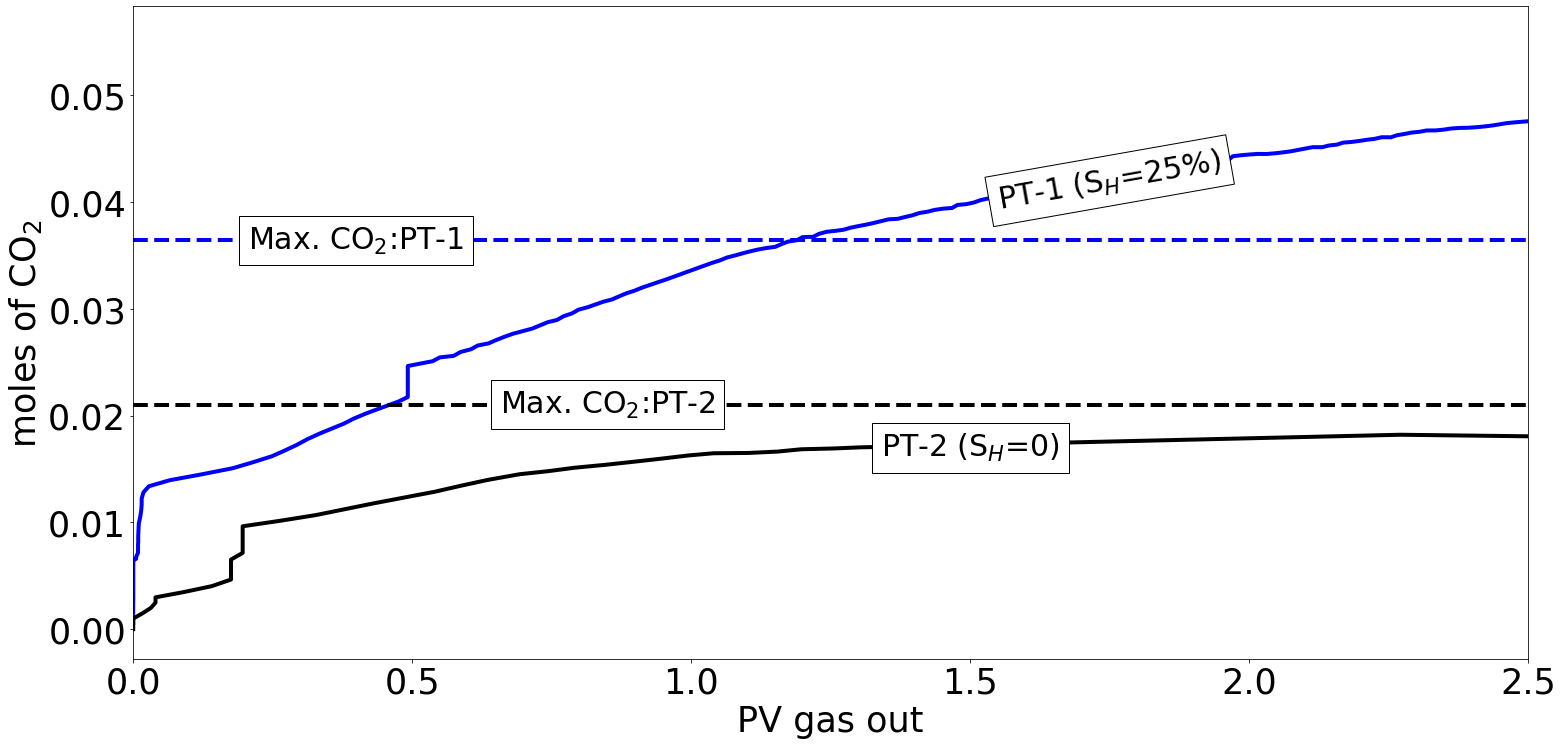

In [42]:
fig=plt.figure(figsize=(25,12))
plt.rcParams['font.size']=35


plt.plot(df['PV out'],df['CO2 in core'],'-',linewidth=4,color='b',label='CH4')
plt.plot(df2['PV out'],df2['CO2 in core'],'-',linewidth=4,color='k',label='CO2')

#plt1.plot(df2['PV out']/5,df2['N2 in core']/1.75,'--',linewidth=3,color='purple',label='N2')
#plt.plot(df['PV out'],df['max CO2'],'-',linewidth=3,color='black',label='N2')
plt.axhline(.021,0,1000,ls='--',linewidth=4,color='black')
plt.axhline(.0364,0,1000,ls='--',linewidth=4,color='blue')

plt.xlabel('PV gas out')
plt.xlim([0,2.5])
#plt.ylim([0,.05])
plt.ylabel('moles of CO$_2$')
#plt.legend(loc='best')

plt.annotate("PT-1 (S$_H$=25%)",xy=(1.75, 0.042), xycoords='data',
                  size=30, va="center", ha="center",rotation=10,
                  bbox=dict(boxstyle="square", fc="w"),)
plt.annotate("PT-2 (S$_H$=0)",xy=(1.5, 0.017), xycoords='data',
                  size=30, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)
plt.annotate("Max. CO$_2$:PT-2",xy=(.85, 0.021), xycoords='data',
                  size=30, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)
plt.annotate("Max. CO$_2$:PT-1",xy=(.4, 0.0364), xycoords='data',
                  size=30, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)
